In [2]:
# a few basic imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report
import plotly.express as px
import plotly.graph_objects as go
import os

In [3]:
#ignore warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [4]:
!pip install transformers datasets torch accelerate evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.1/75.1 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.3/150.3 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.9/193.9 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 65.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.4/242.4 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 221.6/221.6 kB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.3/377.3 kB 34.3 MB/s eta 0:00:00


In [5]:
!pip install tf-keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 885.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 49.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 55.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 56.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 7.5 MB/s eta 0:00:00


In [6]:
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
import torch
import evaluate

In [7]:
from datasets import load_dataset

In [8]:
# Load full ANLI dataset
dataset = load_dataset("facebook/anli", "plain_text")

# Use only Round 2 splits
train_ds = dataset["train_r2"]
val_ds = dataset["dev_r2"]
test_ds = dataset["test_r2"]

print(train_ds)
print(val_ds)
print(test_ds)

README.md: 0.00B [00:00, ?B/s]

plain_text/train_r1-00000-of-00001.parqu(…):   0%|          | 0.00/3.14M [00:00<?, ?B/s]

plain_text/dev_r1-00000-of-00001.parquet:   0%|          | 0.00/351k [00:00<?, ?B/s]

plain_text/test_r1-00000-of-00001.parque(…):   0%|          | 0.00/353k [00:00<?, ?B/s]

plain_text/train_r2-00000-of-00001.parqu(…):   0%|          | 0.00/6.53M [00:00<?, ?B/s]

plain_text/dev_r2-00000-of-00001.parquet:   0%|          | 0.00/351k [00:00<?, ?B/s]

plain_text/test_r2-00000-of-00001.parque(…):   0%|          | 0.00/362k [00:00<?, ?B/s]

plain_text/train_r3-00000-of-00001.parqu(…):   0%|          | 0.00/14.3M [00:00<?, ?B/s]

plain_text/dev_r3-00000-of-00001.parquet:   0%|          | 0.00/434k [00:00<?, ?B/s]

plain_text/test_r3-00000-of-00001.parque(…):   0%|          | 0.00/435k [00:00<?, ?B/s]

Generating train_r1 split:   0%|          | 0/16946 [00:00<?, ? examples/s]

Generating dev_r1 split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test_r1 split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating train_r2 split:   0%|          | 0/45460 [00:00<?, ? examples/s]

Generating dev_r2 split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test_r2 split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating train_r3 split:   0%|          | 0/100459 [00:00<?, ? examples/s]

Generating dev_r3 split:   0%|          | 0/1200 [00:00<?, ? examples/s]

Generating test_r3 split:   0%|          | 0/1200 [00:00<?, ? examples/s]

Dataset({
    features: ['uid', 'premise', 'hypothesis', 'label', 'reason'],
    num_rows: 45460
})
Dataset({
    features: ['uid', 'premise', 'hypothesis', 'label', 'reason'],
    num_rows: 1000
})
Dataset({
    features: ['uid', 'premise', 'hypothesis', 'label', 'reason'],
    num_rows: 1000
})


In [9]:
import torch_xla.core.xla_model as xm

# Set device to TPU
device = xm.xla_device()
print("Using device:", device)

Using device: xla:0


**EDA**

In [10]:
#EDA
#Printing dataset sizes
print(f"\nDataset Sizes:")
print(f"  Training:   {len(train_ds):,} examples")
print(f"  Validation: {len(val_ds):,} examples")
print(f"  Test:       {len(test_ds):,} examples")


Dataset Sizes:
  Training:   45,460 examples
  Validation: 1,000 examples
  Test:       1,000 examples


In [11]:
# Convert to pandas for easier EDA
train_df = pd.DataFrame(train_ds)
val_df = pd.DataFrame(val_ds)
test_df = pd.DataFrame(test_ds)

In [12]:
#basic dataset info
print(train_df.info())
print("\nSample Data:")
print(train_df.head(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45460 entries, 0 to 45459
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   uid         45460 non-null  object
 1   premise     45460 non-null  object
 2   hypothesis  45460 non-null  object
 3   label       45460 non-null  int64 
 4   reason      45460 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.7+ MB
None

Sample Data:
                                    uid  \
0  245475c4-6225-4f5c-b945-e13e0e988fc8   
1  5837ee91-4527-45b7-bd03-5f0a495d71af   
2  ed5c37ab-77c5-4dbc-ba75-8fd617b19712   

                                             premise  \
0  Topi Raja Sweety Roja is a 1996 Telugu comedy ...   
1  Idris Sultan (born January 1993) is a Tanzania...   
2  Idris Sultan (born January 1993) is a Tanzania...   

                                          hypothesis  label reason  
0        The lead role was played by Rajendra Prasad      0         
1      

In [13]:
# Dataset Structure
print("\n Dataset Structure:")
print(f"Columns: {train_df.columns.tolist()}")
print(f"\nFirst example:")
print(f"Premise: {train_df.iloc[0]['premise']}")
print(f"Hypothesis: {train_df.iloc[0]['hypothesis']}")
print(f"Label: {train_df.iloc[0]['label']}")


 Dataset Structure:
Columns: ['uid', 'premise', 'hypothesis', 'label', 'reason']

First example:
Premise: Topi Raja Sweety Roja is a 1996 Telugu comedy film, produced by Dr. A. Vijayalakshmi on Sri Sai Madhavi Productions banner and directed by Dr. N. Siva Prasad. Starring Rajendra Prasad, Roja in the lead roles and music also composed by "Hero" Rajendra Prasad.
Hypothesis: The lead role was played by Rajendra Prasad
Label: 0


In [14]:
#Missing Values
print(f"\n Missing values:")
print(train_df.isnull().sum())


 Missing values:
uid           0
premise       0
hypothesis    0
label         0
reason        0
dtype: int64



 Label Distribution (Training Set):
label_name
neutral          20959
entailment       14448
contradiction    10053
Name: count, dtype: int64

Percentages:
label_name
neutral          46.104267
entailment       31.781786
contradiction    22.113946
Name: proportion, dtype: float64


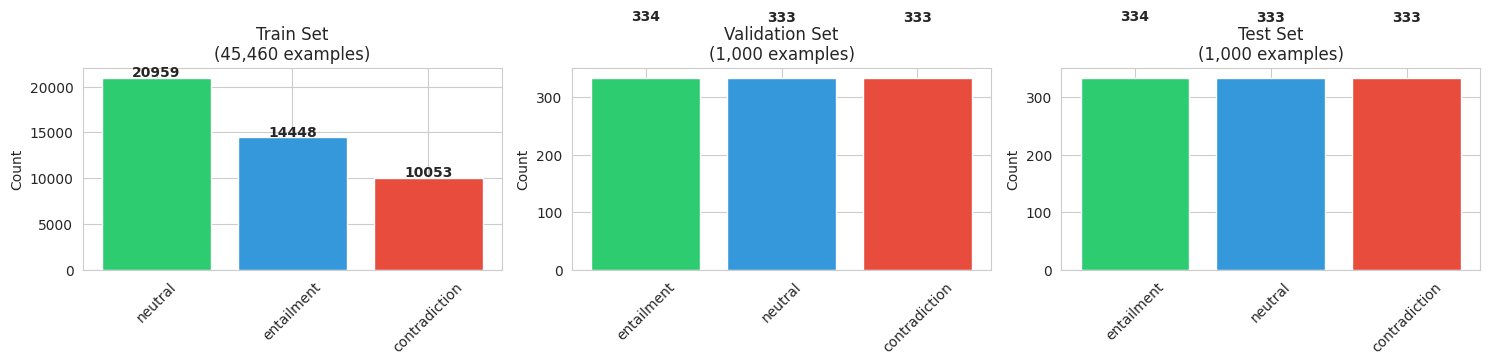

In [15]:
# Label Distribution
label_map = {0: 'entailment', 1: 'neutral', 2: 'contradiction'}
train_df['label_name'] = train_df['label'].map(label_map)
val_df['label_name'] = val_df['label'].map(label_map)
test_df['label_name'] = test_df['label'].map(label_map)

print("\n Label Distribution (Training Set):")
print(train_df['label_name'].value_counts())
print(f"\nPercentages:")
print(train_df['label_name'].value_counts(normalize=True) * 100)

# Visualize label distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for idx, (df, title) in enumerate([(train_df, 'Train'),
                                     (val_df, 'Validation'),
                                     (test_df, 'Test')]):
    label_counts = df['label_name'].value_counts()
    axes[idx].bar(label_counts.index, label_counts.values,
                  color=['#2ecc71', '#3498db', '#e74c3c'])
    axes[idx].set_title(f'{title} Set\n({len(df):,} examples)')
    axes[idx].set_ylabel('Count')
    axes[idx].tick_params(axis='x', rotation=45)
    for i, v in enumerate(label_counts.values):
        axes[idx].text(i, v + 100, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()



 Text Length Analysis:

Length Statistics:
        premise_len  hypothesis_len     total_len
count  45460.000000    45460.000000  45460.000000
mean      53.997800        9.952178     63.949978
std        8.163158        5.335210      9.912140
min       33.000000        3.000000     37.000000
25%       47.000000        7.000000     57.000000
50%       54.000000        9.000000     64.000000
75%       60.000000       11.000000     70.000000
max       76.000000       65.000000    136.000000


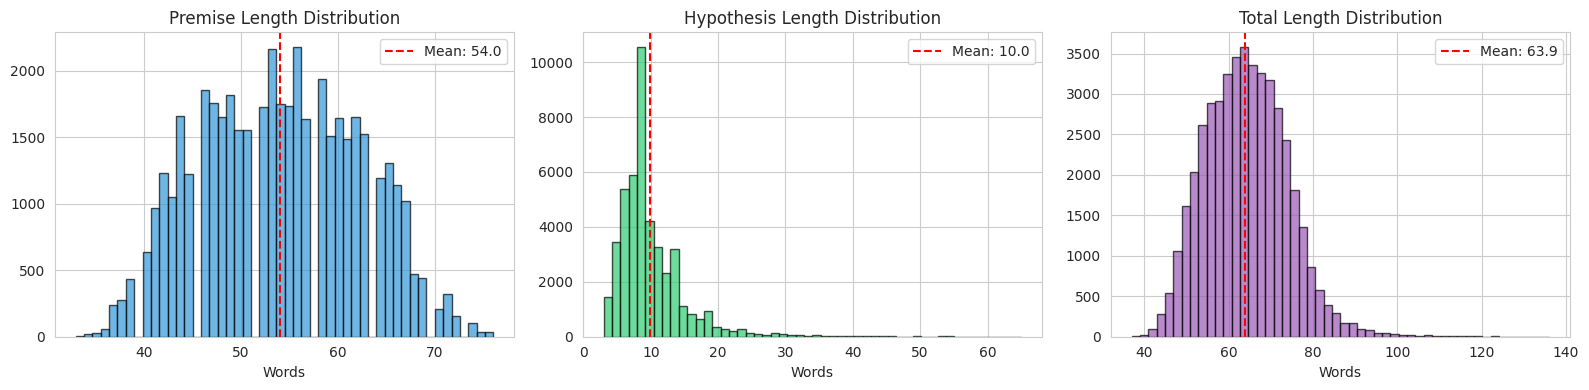

In [16]:
# Text Length Analysis
print("\n Text Length Analysis:")
train_df['premise_len'] = train_df['premise'].apply(lambda x: len(x.split()))
train_df['hypothesis_len'] = train_df['hypothesis'].apply(lambda x: len(x.split()))
train_df['total_len'] = train_df['premise_len'] + train_df['hypothesis_len']

print("\nLength Statistics:")
print(train_df[['premise_len', 'hypothesis_len', 'total_len']].describe())

# Visualize length distributions
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

axes[0].hist(train_df['premise_len'], bins=50, alpha=0.7, color='#3498db', edgecolor='black')
axes[0].axvline(train_df['premise_len'].mean(), color='red', linestyle='--',
                label=f'Mean: {train_df["premise_len"].mean():.1f}')
axes[0].set_title('Premise Length Distribution')
axes[0].set_xlabel('Words')
axes[0].legend()

axes[1].hist(train_df['hypothesis_len'], bins=50, alpha=0.7, color='#2ecc71', edgecolor='black')
axes[1].axvline(train_df['hypothesis_len'].mean(), color='red', linestyle='--',
                label=f'Mean: {train_df["hypothesis_len"].mean():.1f}')
axes[1].set_title('Hypothesis Length Distribution')
axes[1].set_xlabel('Words')
axes[1].legend()

axes[2].hist(train_df['total_len'], bins=50, alpha=0.7, color='#9b59b6', edgecolor='black')
axes[2].axvline(train_df['total_len'].mean(), color='red', linestyle='--',
                label=f'Mean: {train_df["total_len"].mean():.1f}')
axes[2].set_title('Total Length Distribution')
axes[2].set_xlabel('Words')
axes[2].legend()

plt.tight_layout()
plt.show()

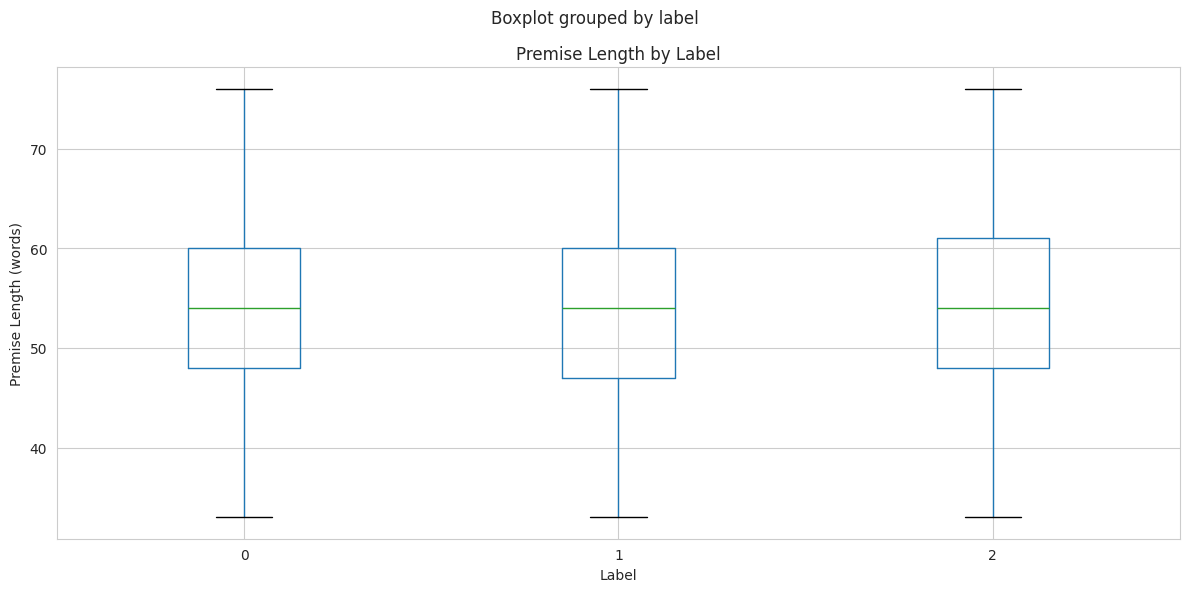

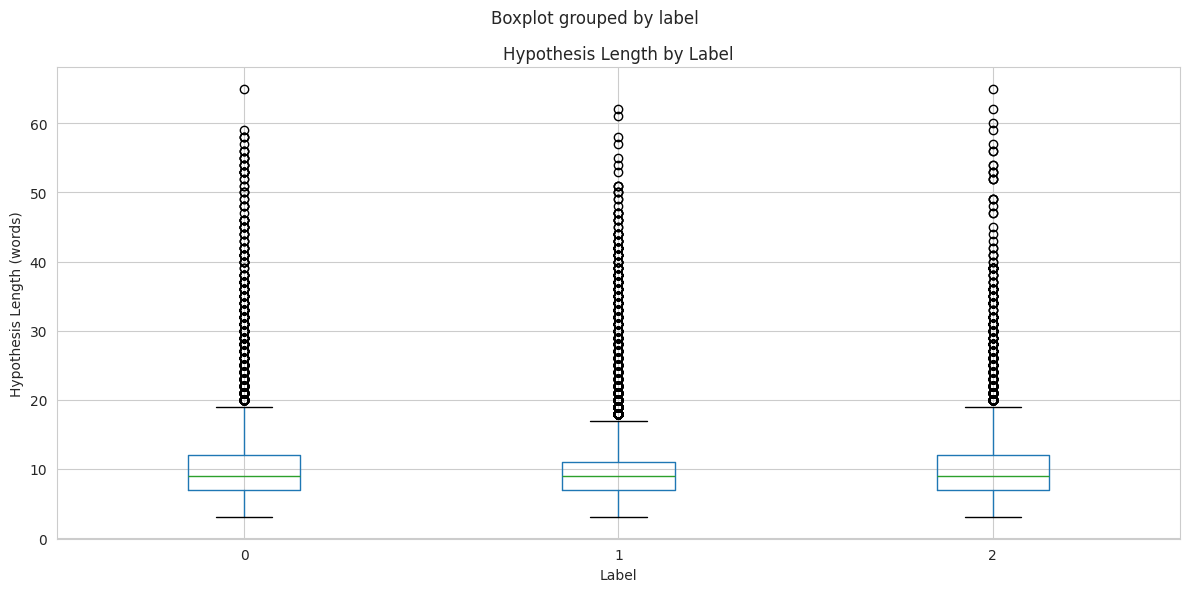

In [17]:
#boxplots
# Box plot for premise length
label_names = {0: 'Entailment', 1: 'Neutral', 2: 'Contradiction'}
train_df.boxplot(column='premise_len', by='label')
plt.xlabel('Label')
plt.ylabel('Premise Length (words)')
plt.title('Premise Length by Label')
plt.tight_layout()
plt.show()

# Box plot for hypothesis length
train_df.boxplot(column='hypothesis_len', by='label')
plt.xlabel('Label')
plt.ylabel('Hypothesis Length (words)')
plt.title('Hypothesis Length by Label')
plt.tight_layout()
plt.show()

In [18]:
# Sample Examples by label
print("\nSample Examples from Each Class:")
for label in [0, 1, 2]:
    print('\n')
    print(f"Label: {label_map[label].upper()}")
    sample = train_df[train_df['label'] == label].iloc[0]
    print(f"Premise: {sample['premise']}")
    print(f"Hypothesis: {sample['hypothesis']}")
    print('\n')


Sample Examples from Each Class:


Label: ENTAILMENT
Premise: Topi Raja Sweety Roja is a 1996 Telugu comedy film, produced by Dr. A. Vijayalakshmi on Sri Sai Madhavi Productions banner and directed by Dr. N. Siva Prasad. Starring Rajendra Prasad, Roja in the lead roles and music also composed by "Hero" Rajendra Prasad.
Hypothesis: The lead role was played by Rajendra Prasad




Label: NEUTRAL
Premise: Have a Little Faith is a Hallmark Hall of Fame television movie. The film debuted on ABC on November 27, 2011, as the first "Hallmark Hall of Fame" film broadcast since CBS cancelled the series earlier in 2011. It was the first "Hallmark Hall of Fame" film broadcast on ABC since 1995.
Hypothesis: Have a Little Faith was the only film to be inducted into the Hallmark Hall of Fame.




Label: CONTRADICTION
Premise: Nantwich Town Football Club is a semi-professional football club based in Nantwich, Cheshire, England. The club was founded in 1884 and is nicknamed "The Dabbers", a reference t

**DATA PRE-PROCESSING**

In [19]:
# Data Pre-processing (Tokenizer and stuff)
#model name
model_name = "microsoft/deberta-v3-base"
#get the tokenizer for the model
tokenizer  = AutoTokenizer.from_pretrained(model_name)

max_length = 256

def preprocess_fn(examples):
    # tokenize premise + hypothesis
    return tokenizer(
        examples["premise"],
        examples["hypothesis"],
        truncation=True,
        padding="max_length",
        max_length=max_length,
    )

train_enc = train_ds.map(preprocess_fn, batched=True)
eval_enc  = val_ds.map(preprocess_fn, batched=True)
test_enc  = test_ds.map(preprocess_fn, batched=True)

# rename label column
train_enc = train_enc.rename_column("label", "labels")
eval_enc  = eval_enc.rename_column("label", "labels")
test_enc  = test_enc.rename_column("label", "labels")

# Set format for PyTorch
train_enc.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
eval_enc.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
test_enc.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

Map:   0%|          | 0/45460 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

**MODEL TRAINING**

In [20]:
# Load model
# 3 classes
num_labels = 3
# load the transformer model from pretrained with pytorch as the framework
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
# Metrics & compute function
# Define metrics
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
#define the computation function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    acc = accuracy_metric.compute(predictions=preds, references=labels)["accuracy"]
    f1_macro = f1_metric.compute(predictions=preds, references=labels, average="macro")["f1"]
    f1_weighted = f1_metric.compute(predictions=preds, references=labels, average="weighted")["f1"]
    precision = precision_metric.compute(predictions=preds, references=labels, average="macro")["precision"]
    recall = recall_metric.compute(predictions=preds, references=labels, average="macro")["recall"]

    return {
        "accuracy": acc,
        "f1_macro": f1_macro,
        "f1_weighted": f1_weighted,
        "precision": precision,
        "recall": recall
    }

model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

In [22]:
# TrainingArguments
training_args = TrainingArguments(
    output_dir              = "./anli_deberta_v3_tpu",
    per_device_train_batch_size = 8,   # I decided to keep it smaller due to TPU single core => v5e-1  TPU
    per_device_eval_batch_size  = 8,
    num_train_epochs        = 3,
    learning_rate           = 2e-5,
    weight_decay            = 0.01,
    logging_dir             = "./logs",
    logging_steps           = 50,
    # Disabled fused optimizer which may cause mismatch
    optim                   = "adamw_torch_xla",
    eval_strategy           = "epoch",
    save_strategy           = "epoch",
    load_best_model_at_end  = True,
)

In [23]:
# Trainer
trainer = Trainer(
    model            = model,
    args             = training_args,
    train_dataset    = train_enc,
    eval_dataset     = eval_enc,
    tokenizer        = tokenizer,
    compute_metrics  = compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

In [24]:
#Total training steps
print(f"Total training steps: {len(train_enc) // training_args.per_device_train_batch_size * training_args.num_train_epochs}")

Total training steps: 17046


In [25]:
# Train
trainer.train()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted,Precision,Recall
1,0.479000,1.609156,0.466000,0.455283,0.455318,0.468115,0.465897


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted,Precision,Recall
1,0.479000,1.609156,0.466000,0.455283,0.455318,0.468115,0.465897
2,0.249200,2.583769,0.464000,0.461168,0.461176,0.465850,0.463946
3,0.255900,2.805014,0.484000,0.480300,0.480320,0.484759,0.483930


TrainOutput(global_step=17049, training_loss=0.3551343183054855, metrics={'train_runtime': 5012.3418, 'train_samples_per_second': 27.211, 'train_steps_per_second': 3.401, 'total_flos': 1.79420257156608e+16, 'train_loss': 0.3551343183054855, 'epoch': 3.0})

**MODEL EVALUATION**

In [26]:
# Evaluate on test set
test_results = trainer.evaluate(test_enc)
print("Test results:", test_results)

Test results: {'eval_loss': 1.698291540145874, 'eval_accuracy': 0.454, 'eval_f1_macro': 0.4398983252887699, 'eval_f1_weighted': 0.4399733523366154, 'eval_precision': 0.45320685945150735, 'eval_recall': 0.4538340735945527, 'eval_runtime': 19.1254, 'eval_samples_per_second': 52.287, 'eval_steps_per_second': 6.536, 'epoch': 3.0}



Confusion Matrix:
[[207  80  47]
 [109 164  60]
 [154  96  83]]


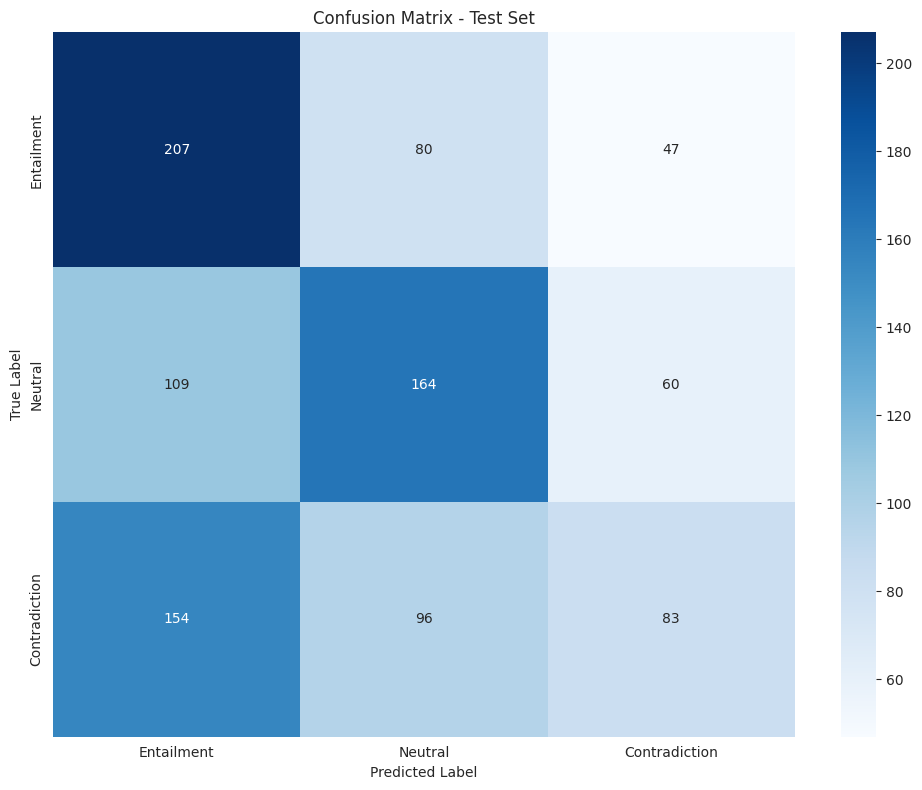


Classification Report:
               precision    recall  f1-score   support

   Entailment     0.4404    0.6198    0.5149       334
      Neutral     0.4824    0.4925    0.4874       333
Contradiction     0.4368    0.2492    0.3174       333

     accuracy                         0.4540      1000
    macro avg     0.4532    0.4538    0.4399      1000
 weighted avg     0.4532    0.4540    0.4400      1000



In [36]:
# Move model to CPU for inference
device = xm.xla_device()
model.to(device)
trainer.model.to(device)

# Get predictions
predictions = trainer.predict(test_enc)
pred_labels = np.argmax(predictions.predictions, axis=-1)
true_labels = predictions.label_ids

# Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)
print("\nConfusion Matrix:")
print(cm)

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=[label_names[i] for i in range(3)],
    yticklabels=[label_names[i] for i in range(3)]
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Test Set')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(
    true_labels,
    pred_labels,
    target_names=[label_names[i] for i in range(3)],
    digits=4
))

In [ ]:
# Move model to CPU before saving
model.to("cpu")
# Save model & tokenizer
model.save_pretrained("./saved_model_debertav3_anli_r2_tpu")
tokenizer.save_pretrained("./saved_model_debertav3_anli_r2_tpu")

In [28]:
from google.colab import files
import shutil

# Compress your folder into a zip
shutil.make_archive("saved_model_debertav3_anli_r2_tpu", 'zip', "./saved_model_debertav3_anli_r2_tpu")

# Download the zip
files.download("saved_model_debertav3_anli_r2_tpu.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>